In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from os import listdir
from scipy.stats import multivariate_normal
from sklearn.metrics import det_curve

In [2]:
BLOCKS = 36
train = []
dev = []
dire = 'D:/College/PRML/Assgn 3/Extracted/'
for path in ['coast', 'forest', 'highway', 'mountain', 'opencountry']:
    files = listdir(dire+path+'/train')
    l = []
    for file in files:
        i = 0
        for line in open(dire+path+'/train/'+file).readlines():
            l.append(line[:-1].split())
            i += 1 
    train.append(pd.DataFrame(l, dtype='float64'))
    
for path in ['coast', 'forest', 'highway', 'mountain', 'opencountry']:
    files = listdir(dire+path+'/dev')
    l = []
    for file in files:
        i = 0
        for line in open(dire+path+'/dev/'+file).readlines():
            l.append(line[:-1].split())
            i += 1 
    dev.append(pd.DataFrame(l, dtype='float64'))

In [3]:
train[0]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.60311,0.45763,0.55387,1.102400e-11,6.695900e-09,1.352200e-09,0.89186,0.22872,0.462570,0.000731,...,0.000932,0.009927,0.007282,0.004838,3.3325,3.1517,3.4068,3.2420,3.5730,3.2970
1,0.60460,0.41023,0.61637,1.474100e-11,3.920700e-09,2.117100e-09,0.55016,0.10849,-0.019499,0.000907,...,0.000731,0.009953,0.008013,0.004712,3.1779,3.2292,2.9213,3.3541,3.3664,3.2194
2,0.60989,0.35695,0.67262,1.154800e-11,2.543000e-09,1.546800e-09,-0.27270,-0.00707,-0.226770,0.000731,...,0.000504,0.008970,0.009020,0.004863,3.3763,3.1826,3.3371,3.4785,3.1448,3.4466
3,0.61630,0.31011,0.72104,2.630300e-11,4.253400e-09,9.594200e-10,0.90407,0.28108,0.028316,0.000831,...,0.000630,0.009550,0.008542,0.005543,3.4614,3.3633,3.2114,3.6543,3.3592,3.3454
4,0.62183,0.26934,0.75899,3.728400e-11,9.079600e-10,1.087100e-09,-0.19791,-0.20388,0.616320,0.000680,...,0.000781,0.009650,0.008113,0.005266,3.3919,3.3647,3.4421,3.5691,3.1709,3.2476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9031,0.52944,0.22754,0.77920,1.881900e-08,1.177300e-05,1.223800e-04,0.42743,0.12420,0.405320,0.000109,...,0.000054,0.011794,0.000054,0.021817,3.1184,2.3032,2.5628,3.1291,2.9128,2.8998
9032,0.50268,0.21878,0.70724,1.146500e-07,5.073300e-06,3.574400e-05,0.80982,-0.64888,0.675920,0.000109,...,0.000054,0.007517,0.000054,0.030860,2.6174,2.4801,1.9792,2.6087,2.9143,2.8344
9033,0.45713,0.20215,0.70111,1.314600e-04,8.276600e-06,2.287600e-05,-0.25451,-1.47490,-1.326900,0.000227,...,0.000328,0.003503,0.002394,0.030793,1.6174,1.9180,1.8718,3.0969,2.0060,2.2764
9034,0.38428,0.20724,0.77198,2.736600e-04,3.168200e-05,1.669000e-04,-1.73080,0.62762,0.540030,0.000227,...,0.000403,0.006727,0.002898,0.024365,2.3261,2.2453,2.4349,2.6741,2.5500,2.6833


In [4]:
test = pd.concat([dev[i] for i in range(5)])
y_test = []
for i in range(5):
    y_test += [i]*(dev[i].shape[0]//36)
y_test = np.array(y_test)

In [5]:
mean = pd.concat([train[i] for i in range(5)]).mean()
std = pd.concat([train[i] for i in range(5)]).std()
for i in range(5):
    train[i] = (train[i] - mean)/std
    dev[i] = (dev[i] - mean)/std

In [18]:
class GMM:
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        
        
    def KMeans(self, X, k, max_iter=100):
        idx = np.random.choice(X.shape[0], k, replace=False)
        X = np.array(X)
        centroids = X[idx, :]
        distances = np.array([_ for _ in [((X-centroids[i])**2).sum(axis=1)**0.5 for i in range(k)]])
        points = np.array([np.argmin(i) for i in distances.T]) 

        for i in range(max_iter): 
            centroids = []
            for idx in range(k):
                temp_cent = X[points==idx].mean(axis=0) 
                centroids.append(temp_cent) 
            centroids = np.vstack(centroids)         
            distances = np.array([_ for _ in [((X-centroids[i])**2).sum(axis=1)**0.5 for i in range(k)]])
            points = np.array([np.argmin(i) for i in distances.T])         
        return points


    def initialize(self, X):    
        
        labels = self.KMeans(X, self.k)  
        X_split = [X[np.full(X.shape[0], i)==labels] for i in range(self.k)]
        self.shape = X.shape
        self.n, self.m = self.shape
        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [np.mean(x, axis=0) for x in X_split]
        self.sigma = [np.cov(x.T) for x in X_split]
        

    def fit(self, X):
        self.initialize(X)
        
        def e_step():
            # E-Step: update weights and phi holding mu and sigma constant
            self.weights = self.predict_weights(X)
            self.phi = self.weights.mean(axis=0)

        def m_step():
            # M-Step: update mu and sigma holding phi and weights constant
            for i in range(self.k):
                weight = self.weights[:, [i]]
                total_weight = weight.sum()
                self.mu[i] = (X * weight).sum(axis=0) / total_weight
                self.sigma[i] = np.cov(X.T, 
                    aweights=(weight/total_weight).flatten(), 
                    bias=True)
                
        for iteration in range(self.max_iter):
            e_step()
            m_step()
        self.multiplier = self.set_multiplier(X)
    
    
    def predict_weights(self, X):
        likelihood = np.zeros( (X.shape[0], self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i],
                allow_singular=True
            )
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    
    def set_multiplier(self, X):
        l = []
        for j in range(X.shape[0]//BLOCKS):
            part = X[j*BLOCKS : (j+1)*BLOCKS]
            likelihood = np.zeros( (BLOCKS, self.k) )
            for i in range(self.k):
                distribution = multivariate_normal(
                    mean=self.mu[i], 
                    cov=self.sigma[i], 
                    allow_singular=True
                )
                likelihood[:,i] = distribution.pdf(part)*self.phi[i]

            numerator = likelihood * self.phi
            denominator = numerator.sum(axis=1)
            j += 1
            l.append(denominator.sum())
        return np.median(np.array(l))
    
    def predict_proba(self, X):
        l = []
        for j in range(X.shape[0]//BLOCKS):
            part = X[j*BLOCKS : (j+1)*BLOCKS]
            likelihood = np.zeros( (BLOCKS, self.k) )
            for i in range(self.k):
                distribution = multivariate_normal(
                    mean=self.mu[i], 
                    cov=self.sigma[i], 
                    allow_singular=True
                )
                likelihood[:,i] = distribution.pdf(part)*self.phi[i]

            numerator = likelihood * self.phi
            denominator = numerator.sum(axis=1)
            j += 1
            l.append(denominator.sum())
        return np.array(l)/self.multiplier
    
    
    def predict(self, X):
        weights = self.predict_weights(X)
        return np.argmax(weights, axis=1)
    
    
    
def predict(test, is_train=False):
    global mean, std
    X = (test - mean)/std if is_train==False else test
    class_prob = pd.DataFrame()
    for i in range(5):
        class_prob[i] = models[i].predict_proba(X)
    return class_prob.idxmax(axis=1)

def predict_proba(test, is_train=False):
    global mean, std
    X = (test - mean)/std if is_train==False else test
    class_prob = pd.DataFrame()
    for i in range(5):
        class_prob[i] = models[i].predict_proba(X)
    summ = class_prob.sum(axis=1)
    for i in range(X.shape[0]//BLOCKS):
        class_prob.iloc[i] = class_prob.iloc[i]/summ[i]
    return class_prob

In [19]:
# dev_acc = []
# k = range(2,13)
# for _ in k:
#     models = []
#     for i in range(5):
#         freq = 0
#         while True:
#             model = GMM(_)
#             try:
#                 model.fit(train[i])
#             except ValueError:
#                 print('ValueError', freq)
#                 freq += 1
#                 continue
#             print('Model created for', i)
#             break
#         models.append(model)
    
#     l = []
#     for i in range(5):
#         try:
#             count = predict(dev[i], is_train=True).value_counts()[i]
#         except KeyError:
#             count = 0
#         l.append(count/(dev[i].shape[0]//36))
#     dev_acc.append(l)
#     print()

In [20]:
# pd.DataFrame(dev_acc, index=k, columns=['coast', 'forest', 'highway', 'mountain', 'opencountry'])

In [21]:
# pd.DataFrame(dev_acc, index=k, columns=['coast', 'forest', 'highway', 'mountain', 'opencountry']).idxmax(axis=0)

In [22]:
k = [6,6,2,4,2]
models = []
for i in range(5):
    while True:
        model = GMM(k[i])
        try:
            model.fit(train[i])
        except ValueError:
            print('ValueError', freq)
            freq += 1
            continue
        print('Model created for', i)
        break
    models.append(model)

Model created for 0
Model created for 1
Model created for 2
Model created for 3
Model created for 4


In [23]:
for i in range(5):
    print(predict(train[i], is_train=True).value_counts()[i]/(train[i].shape[0]//BLOCKS))

0.5059760956175299
0.45414847161572053
0.34615384615384615
0.5977011494252874
0.3344947735191638


In [24]:
for i in range(5):
    print(predict(dev[i], is_train=True).value_counts()[i]/(dev[i].shape[0]//BLOCKS))

0.5753424657534246
0.3787878787878788
0.057692307692307696
0.41333333333333333
0.4268292682926829


In [25]:
def ROC(probabilities, C, n_classes, Actual):
    probabilities = np.array(probabilities)
    n = probabilities.shape[0]
    S = pd.DataFrame()
    for j in range(n_classes):
        S[j] = probabilities[:, j] * C[j]
    S = S.to_numpy()
    TPR = []; FPR = []

    for threshold in np.linspace(S.min(), S.max(), 1000):
        TP = FP = TN = FN = 0.0

        for i in range (n):
            for j in range (n_classes):
                if(S[i,j] >= threshold):
                    if Actual[i] == j:
                        TP += 1
                    else:
                        FP += 1

                else:
                    if Actual[i] == j:
                        FN += 1
                    else:
                        TN += 1

        TPR.append(TP/(TP + FN))
        FPR.append (FP/(FP+ TN))

    FPR, TPR = zip(*sorted (zip (FPR, TPR)))
    plt.plot (FPR, TPR)
    return np.trapz (TPR, FPR)

0.718038834390276

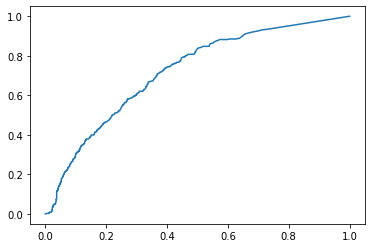

In [26]:
ROC(predict_proba(test, is_train=False), [.2,.2,.2,.2,.2], 5, y_test)

In [27]:
df_confusion = pd.crosstab(y_test, predict(test), rownames=['Actual'], colnames=['Predicted'])

In [28]:
df_confusion

Predicted,0,1,2,3,4
Actual,,,,,
0,42,0,4,19,8
1,1,25,0,7,33
2,40,0,3,5,4
3,17,1,5,31,21
4,18,10,0,19,35


In [29]:
accuracy = sum([df_confusion[i][i] for i in range(5)])/y_test.shape[0]
accuracy

0.39080459770114945